In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as srn
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string
from wordcloud import WordCloud

In [153]:
data = pd.read_csv("data.csv")
data = data.dropna()
data = data.drop_duplicates()
data = data.reset_index(drop=True)

In [154]:
data.head()

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     19999 non-null  object
 1   Emotion  19999 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [156]:
data.describe(include="all")

,Text,Emotion
count,19999,19999
unique,19948,6
top,i will feel as though i am accepted by as well...,joy
freq,2,6760


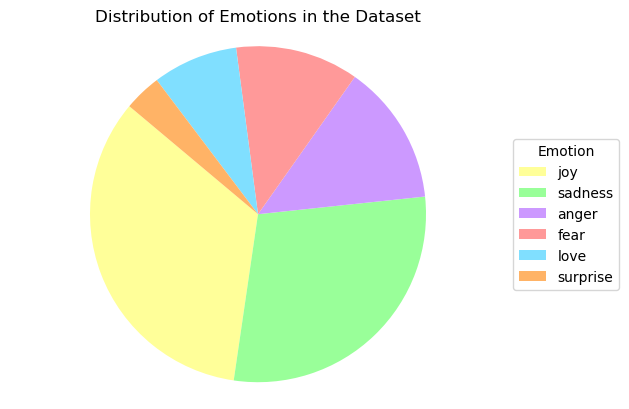

In [157]:
counts = data['Emotion'].value_counts()
colors=["#FFFF99", "#99FF99", "#CC99FF", "#FF9999", "#80DFFF", "#FFB366"]
#lIGHT YELLOW, LIGHT GREEN, LIGHT PURPLE, LIGHT RED, LIGHT BLUE, LIGHT ORANGE
plt.pie(counts,startangle=140, colors=colors)

plt.legend(counts.index, title='Emotion', loc='center left', bbox_to_anchor=(1, 0.5))

plt.axis('equal')
plt.title('Distribution of Emotions in the Dataset')
plt.show()

In [160]:
def data_preprocessing(text):
    
    tokens = word_tokenize(text)
    
    tokens = [token.lower() for token in tokens]
    
    tokens = [token for token in tokens if token not in string.punctuation]
    
    stopword_list = list(stopwords.words("english"))
    stopword_list.append('feel')
    stopword_list.append('like')
    stopword_list.
    avoid_these = ['not', 'very', 'too', 'never']
    
    result=[]
    for token in tokens:
        if token not in stopword_list:
            result.append(token)
        elif token in avoid_these:    
            result.append(token)
    tokens = result        
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    
    return ' '.join(tokens)


In [161]:
data['Text']=data['Text'].apply(data_preprocessing)

In [162]:
data.head()

,Text,Emotion
0,im feel rather rotten im not very ambitious right,sadness
1,im update blog shitty,sadness
2,never make separate ever want ashamed,sadness
3,leave bouquet red yellow tulips arm feel sligh...,joy
4,feel little vain one,sadness


In [163]:
memory_usage = data.memory_usage(deep=True).sum()

print(f"Memory usage of the DataFrame: {memory_usage / (1024**2):.2f} MB")

Memory usage of the DataFrame: 3.30 MB


In [164]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Assuming 'data' is your DataFrame with a 'Text' column after preprocessing

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Text'])

# Encode the target variable 'Emotion'
label_encoder = LabelEncoder()
data['Emotion_encoded'] = label_encoder.fit_transform(data['Emotion'])

# Feature selection using chi-square test
num_features_to_select = 1000  # You can adjust this parameter
chi2_selector = SelectKBest(chi2, k=num_features_to_select)
tfidf_matrix_selected = chi2_selector.fit_transform(tfidf_matrix, data['Emotion_encoded'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_selected, data['Emotion_encoded'], test_size=0.2, random_state=42)

# Train a classifier (for example, Support Vector Machine)
classifier = SVC()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8745


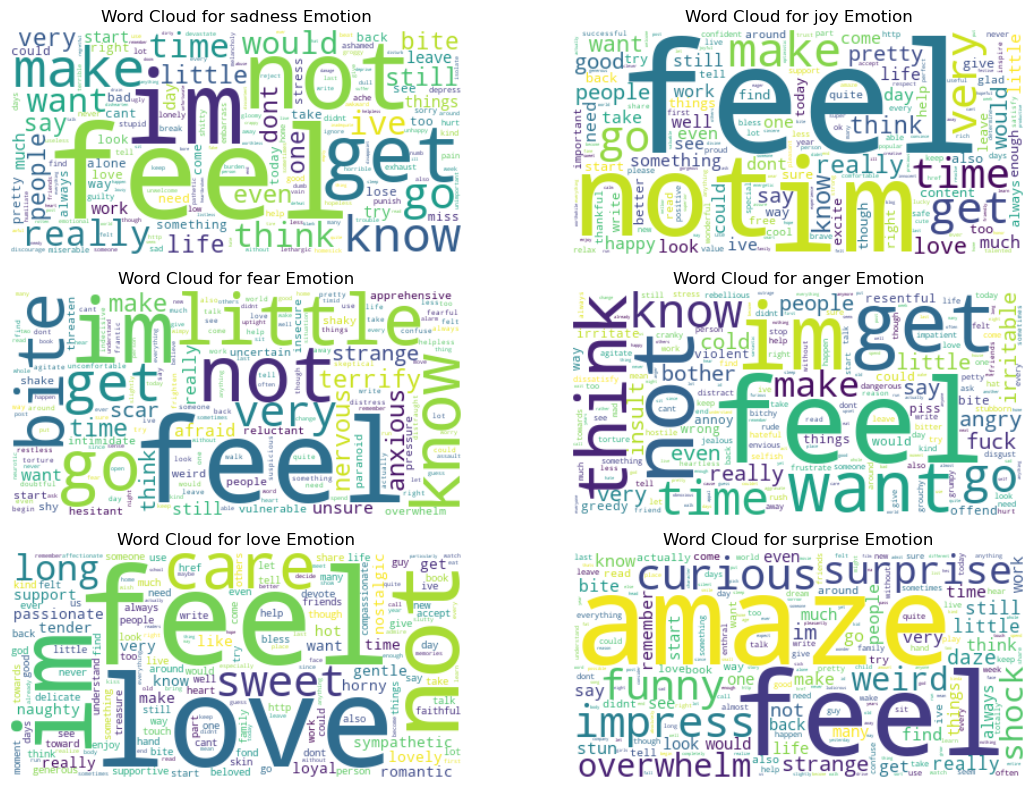

In [165]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming 'data' is your DataFrame with 'Text', 'Emotion', and 'Emotion_encoded' columns

# Create a dictionary to store the text for each emotion
emotion_texts = {}
for emotion in data['Emotion'].unique():
    emotion_texts[emotion] = ' '.join(data[data['Emotion'] == emotion]['Text'])

# Create a 3x2 subplot matrix for the word clouds
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

# Flatten the subplot matrix for easy iteration
axes = axes.flatten()

# Create word clouds for each emotion and plot on the corresponding subplot
for i, (emotion, text) in enumerate(emotion_texts.items()):
    # Vectorize the text for the current emotion
    emotion_vectorized = tfidf_vectorizer.transform([text])
    
    # Get feature names from the vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get the TF-IDF values for the features
    tfidf_values = emotion_vectorized.toarray()[0]

    # Create a dictionary with feature names and their TF-IDF values
    word_tfidf_dict = dict(zip(feature_names, tfidf_values))

    # Create a WordCloud
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_tfidf_dict)

    # Plot the WordCloud on the corresponding subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Word Cloud for {emotion} Emotion')
    axes[i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
